# Previsão de Preço de Passagens Aéreas

Problema de negócio: prever o preço de uma passagem para permitir que a plataforma ofereça preços mais competitivos e proteja margem.

Saída desejada: modelo/regressor que prediz price com boa precisão (RMSE baixo) + app Streamlit para demonstrar previsões.

Valor de negócio: redução do erro de precificação (ex.: hoje perda estimada de $5000 por venda) — traduzir melhora do RMSE em ganho financeiro.

---


## 1. Importações e leitura dos dados

Carregamento das bibliotecas e o dataset. Utilizo a prática de criar `df1` como cópia para não preservar os dados originais.

In [4]:

# Imports básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Caminho do dataset - ajuste se necessário
DATA_PATH = Path('../data/dados_passagens_V1.csv')

if not DATA_PATH.exists():
    print(f"Arquivo não encontrado em {DATA_PATH}. Verifique o caminho e coloque o CSV na pasta 'data' do repositório.")
else:
    print('Arquivo encontrado:', DATA_PATH)
    
# Carregar
df = pd.read_csv(DATA_PATH)
# Criar cópia de trabalho seguindo sua prática
df1 = df.copy()

# Mostrar informações iniciais
print('Shape:', df1.shape)
display(df1.head())
display(df1.info())
display(df1.describe(include='all').T)


Arquivo encontrado: ..\data\dados_passagens_V1.csv
Shape: (300153, 12)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,300153.0,NaN,NaN,NaN,150076.0,86646.852011,0.0,75038.0,150076.0,225114.0,300152.0
airline,300153,6,Vistara,127859,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flight,300153,1561,UK-706,3235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source_city,300153,6,Delhi,61343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
departure_time,300153,6,Morning,71146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stops,300153,3,one,250863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_time,300153,6,Night,91538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
destination_city,300153,6,Mumbai,59097,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,300153,2,Economy,206666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,300153.0,NaN,NaN,NaN,12.221021,7.191997,0.83,6.83,11.25,16.17,49.83


## 2. Limpeza inicial

- Remover colunas irrelevantes como `Unnamed: 0`.
- Padronizar nomes das colunas.
- Converter tipos quando necessário (durations/dates).

In [5]:

# 2. Limpeza inicial
df1.columns = [c.strip().lower().replace(' ', '_') for c in df1.columns]
print('Colunas padronizadas:', df1.columns.tolist())

# Remover coluna de índice exportada se existir
for c in df1.columns:
    if 'unnamed' in c:
        df1.drop(columns=[c], inplace=True)
        print('Removida coluna:', c)

# Conversão de duration - se já for numérico, mantemos. Caso esteja em formato '2h 30m' usamos parsing.
import re
def parse_duration_to_hours(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return x
    s = str(x)
    h = re.search(r"(\d+)h", s)
    m = re.search(r"(\d+)m", s)
    hours = float(h.group(1)) if h else 0.0
    minutes = float(m.group(1)) if m else 0.0
    total = hours + minutes/60.0
    # Se o valor parecer um float já (ex: '2.17'), tenta converter
    try:
        if total == 0.0:
            return float(s)
    except:
        pass
    return total

if 'duration' in df1.columns:
    df1['duration'] = df1['duration'].apply(parse_duration_to_hours)

# Garantir tipos numéricos
for c in ['days_left','price','stops','duration']:
    if c in df1.columns:
        df1[c] = pd.to_numeric(df1[c], errors='coerce')

# Mostrar nulos
print('\nNulos por coluna:')
print(df1.isnull().sum())

# Mostrar primeiras linhas novamente
display(df1.head())


Colunas padronizadas: ['unnamed:_0', 'airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'price']
Removida coluna: unnamed:_0

Nulos por coluna:
airline                  0
flight                   0
source_city              0
departure_time           0
stops               300153
arrival_time             0
destination_city         0
class                    0
duration                 0
days_left                0
price                    0
dtype: int64


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,NaN,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,NaN,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,NaN,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,NaN,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,NaN,Morning,Mumbai,Economy,2.33,1,5955


## 3. EDA (Exploratory Data Analysis)

Explorar a distribuição do preço e relações com variáveis importantes.

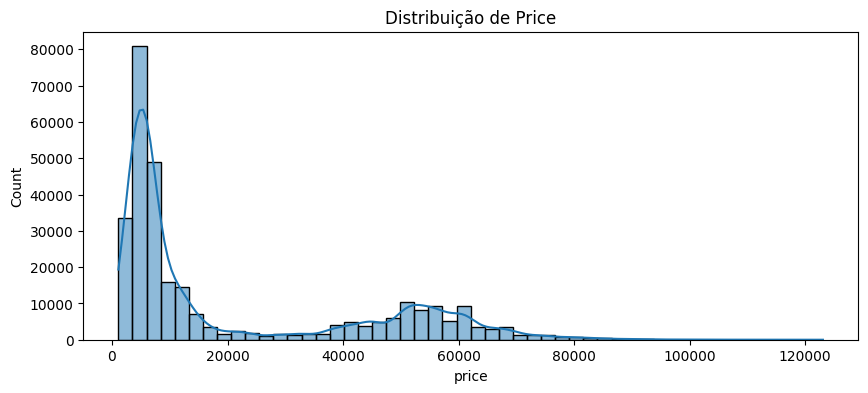

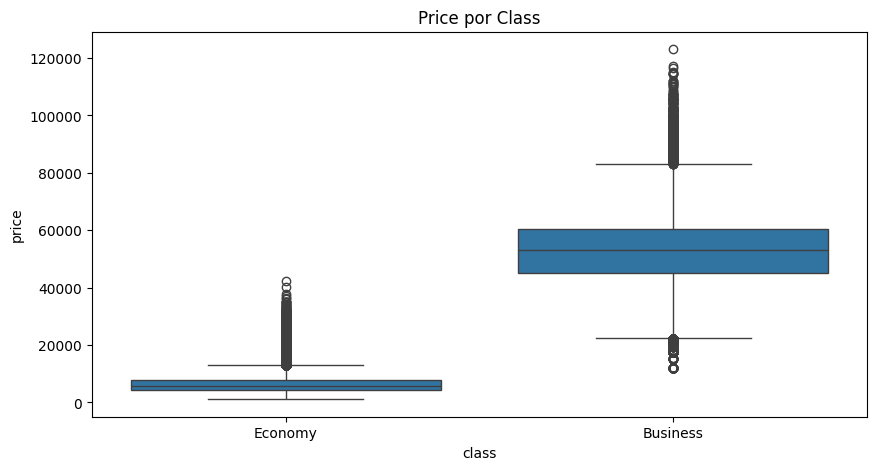

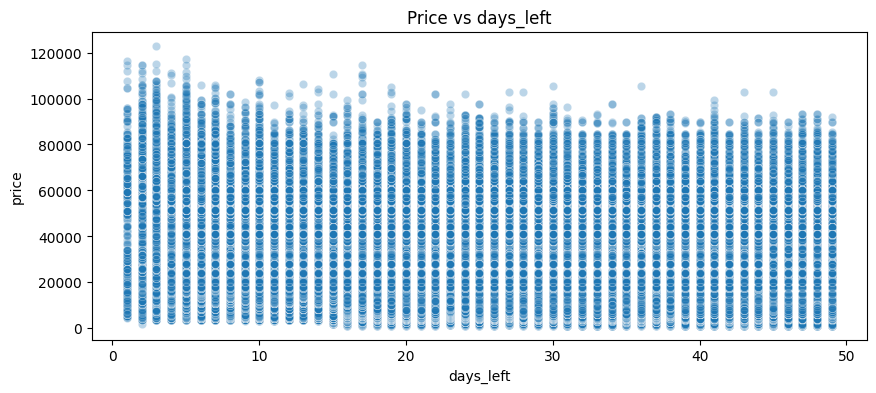

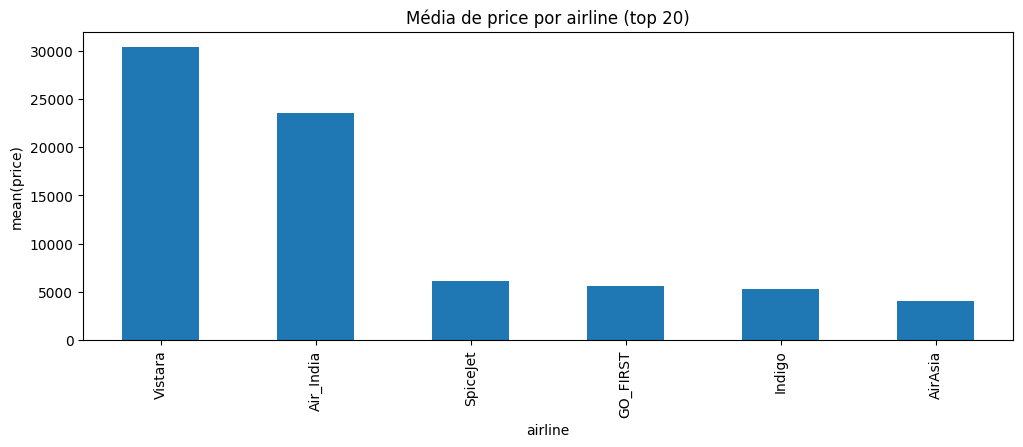

In [6]:

# Distribuição de price
plt.figure(figsize=(10,4))
sns.histplot(df1['price'].dropna(), bins=50, kde=True)
plt.title('Distribuição de Price')
plt.xlabel('price')
plt.show()

# Boxplot por class
if 'class' in df1.columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(x='class', y='price', data=df1)
    plt.title('Price por Class')
    plt.show()

# Price vs days_left
if 'days_left' in df1.columns:
    plt.figure(figsize=(10,4))
    sns.scatterplot(x='days_left', y='price', data=df1, alpha=0.3)
    plt.title('Price vs days_left')
    plt.show()

# Price por airline (média) - top 20
if 'airline' in df1.columns:
    mean_by_airline = df1.groupby('airline')['price'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12,4))
    mean_by_airline.head(20).plot(kind='bar')
    plt.title('Média de price por airline (top 20)')
    plt.ylabel('mean(price)')
    plt.show()


## 4. Feature Engineering

Criação variáveis que façam sentido para o negócio. Ex: rota, período do dia e categorias de antecedência.

In [7]:

# Rota
if {'source_city','destination_city'}.issubset(df1.columns):
    df1['route'] = df1['source_city'].astype(str) + '_' + df1['destination_city'].astype(str)

# Extrair período a partir de departure_time (ex: 'Morning', 'Evening', 'Early_Morning', 'Night'...)
def extract_hour_token(s):
    if pd.isna(s): return 'unknown'
    s = str(s)
    # se for texto já categórico como 'Morning' retorna ele
    if any(k in s for k in ['Morning','Evening','Night','Afternoon','Early_Morning','Early_Morning']):
        return s
    # tentar encontrar hora no formato HH:MM
    m = re.search(r"(\d{1,2}):?(\d{2})?", s)
    if m:
        h = int(m.group(1))
        if h <= 5: return 'madrugada'
        if h <= 11: return 'manha'
        if h <= 17: return 'tarde'
        return 'noite'
    return s

if 'departure_time' in df1.columns:
    df1['departure_period'] = df1['departure_time'].apply(extract_hour_token)

# Categorizar days_left
def days_cat(x):
    if pd.isna(x): return 'unknown'
    x = int(x)
    if x <= 3: return 'ultima_hora'
    if x <= 14: return 'curto_prazo'
    if x <= 60: return 'medio_prazo'
    return 'alta_antecedencia'

if 'days_left' in df1.columns:
    df1['days_category'] = df1['days_left'].apply(days_cat)

# Agrupar rotas raras: reduzir cardinalidade mantendo top N
if 'route' in df1.columns:
    top_routes = df1['route'].value_counts().nlargest(40).index
    df1['route_reduced'] = df1['route'].where(df1['route'].isin(top_routes), other='other')

# Duration buckets
if 'duration' in df1.columns:
    df1['duration_cat'] = pd.cut(df1['duration'], bins=[-1,1,3,6,24,999], labels=['muito_curto','curto','medio','longo','muito_longo'])

display(df1[['airline','route_reduced' if 'route_reduced' in df1.columns else 'route','departure_time','departure_period','days_left','days_category','duration','duration_cat']].head())


,airline,route_reduced,departure_time,departure_period,days_left,days_category,duration,duration_cat
0,SpiceJet,Delhi_Mumbai,Evening,Evening,1,ultima_hora,2.17,curto
1,SpiceJet,Delhi_Mumbai,Early_Morning,Early_Morning,1,ultima_hora,2.33,curto
2,AirAsia,Delhi_Mumbai,Early_Morning,Early_Morning,1,ultima_hora,2.17,curto
3,Vistara,Delhi_Mumbai,Morning,Morning,1,ultima_hora,2.25,curto
4,Vistara,Delhi_Mumbai,Morning,Morning,1,ultima_hora,2.33,curto


## 5. Preparação para modelagem — Split treino/teste

Separação dos dados antes de ajustar scalers/encoders. Escolha das colunas numéricas e categóricas para o pipeline.

In [8]:
from sklearn.model_selection import train_test_split

# Selecionar colunas iniciais 
target = 'price'
drop_cols = []  # por enquanto não remove 'flight' porque pode ser irrelevante

# Remover colunas irrelevantes
for c in ['flight', 'stops']:
    if c in df1.columns:
        df1.drop(columns=[c], inplace=True)

X = df1.drop(columns=[target])
y = df1[target]

# Simples: selecionar colunas úteis (exclua colunas textuais longas se não for usar)
# Vamos identificar colunas numéricas e categóricas automaticamente
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print('Numéricas:', num_cols)
print('Categóricas:', cat_cols)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train shape:', X_train.shape, 'X_test shape:', X_test.shape)


Numéricas: ['duration', 'days_left']
Categóricas: ['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city', 'class', 'route', 'departure_period', 'days_category', 'route_reduced', 'duration_cat']
X_train shape: (240122, 13) X_test shape: (60031, 13)


## 6. Pipeline: ColumnTransformer + Pipeline

Criando transformações separadas para numéricas e categóricas e testando múltiplos modelos.

Modelos a serem testados: Linear Regression, RandomForest, XGBoost.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import time

# ⭐⭐ SOLUÇÃO OTIMIZADA: ANÁLISE + LIMITAÇÃO INTELIGENTE ⭐⭐
print("=== ANÁLISE DETALHADA + OTIMIZAÇÃO INTELIGENTE ===")

# Identificar colunas com alta cardinalidade (>20 valores únicos)
high_cardinality_cols = []
for col in cat_cols:
    if col in X_train.columns:
        unique_count = X_train[col].nunique()
        if unique_count > 20:
            high_cardinality_cols.append(col)
            print(f"🚨 Coluna problemática '{col}' - {unique_count} valores únicos")

# Manter apenas colunas com cardinalidade baixa/moderada
cat_cols_filtered = [col for col in cat_cols if col not in high_cardinality_cols]
num_cols_filtered = [c for c in num_cols if c in X_train.columns]

print(f"\n✅ Colunas para modelagem:")
print(f"Numéricas: {num_cols_filtered}")
print(f"Categóricas: {cat_cols_filtered}")

# ⭐⭐ CALCULAR DIMENSIONALIDADE ESTIMADA ⭐⭐
print(f"\n📊 ANÁLISE DE DIMENSIONALIDADE:")
total_onehot_columns = 0
for col in cat_cols_filtered:
    if col in X_train.columns:
        unique_count = X_train[col].nunique()
        total_onehot_columns += unique_count
        print(f"   {col}: {unique_count} valores únicos")

total_features = total_onehot_columns + len(num_cols_filtered)
print(f"🚨 TOTAL ESTIMADO: {total_onehot_columns} colunas one-hot + {len(num_cols_filtered)} numéricas = {total_features} features")
print(f"🚨 MATRIZ FINAL: {X_train.shape[0]:,} linhas × {total_features} colunas")

# ⭐⭐ TRANSFORMADORES OTIMIZADOS ⭐⭐
print(f"\n🔧 CONFIGURANDO PIPELINE OTIMIZADO...")

num_transformer = Pipeline([('scaler', StandardScaler())])

# OneHotEncoder OTIMIZADO - mantém todas as colunas mas com controle
cat_transformer = Pipeline([
    ('onehot', OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=False,  # Mais eficiente para datasets grandes
        max_categories=15,    # ⭐ LIMITA categorias por feature - agrupa raras como "outras"
        min_frequency=0.01    # ⭐ Agrupa categorias com menos de 1% de frequência
    ))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols_filtered),
    ('cat', cat_transformer, cat_cols_filtered)
])

# Dicionário para guardar resultados
results = {}

# Função auxiliar ATUALIZADA com timing
def train_evaluate(pipeline, X_tr, X_te, y_tr, y_te, name='model'):
    print(f"\n🔄 Treinando {name}...")
    start_time = time.time()
    
    pipeline.fit(X_tr, y_tr)
    preds = pipeline.predict(X_te)
    
    training_time = time.time() - start_time
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    mae = mean_absolute_error(y_te, preds)
    r2 = r2_score(y_te, preds)
    
    results[name] = {
        'model': pipeline, 
        'rmse': rmse, 
        'mae': mae, 
        'r2': r2,
        'time': training_time
    }
    
    print(f"✅ {name} -> RMSE: {rmse:.2f} | MAE: {mae:.2f} | R2: {r2:.4f} | Tempo: {training_time:.1f}s")
    return pipeline

# ⭐⭐ MODELOS COM CONFIGURAÇÕES OTIMIZADAS ⭐⭐

# Linear Regression pipeline
print("\n" + "="*50)
pipe_lr = Pipeline([('pre', preprocessor), ('lr', LinearRegression())])
pipe_lr = train_evaluate(pipe_lr, X_train, X_test, y_train, y_test, name='LinearRegression')

# Random Forest pipeline OTIMIZADO
pipe_rf = Pipeline([('pre', preprocessor), 
                   ('rf', RandomForestRegressor(
                       n_estimators=50,           # ⭐ Menos árvores para velocidade
                       max_depth=15,              # ⭐ Controla profundidade
                       min_samples_split=20,      # ⭐ Evita overfitting
                       random_state=42, 
                       n_jobs=-1,
                       verbose=1                  # ⭐ Mostra progresso
                   ))])
pipe_rf = train_evaluate(pipe_rf, X_train, X_test, y_train, y_test, name='RandomForest')

# ⭐⭐ ANÁLISE DE RESULTADOS ⭐⭐
print("\n" + "="*50)
print("🎯 RESUMO DOS RESULTADOS:")
print("="*50)
for model_name, metrics in results.items():
    print(f"{model_name:20} | RMSE: {metrics['rmse']:7.2f} | R2: {metrics['r2']:6.4f} | Tempo: {metrics['time']:5.1f}s")

# ⭐⭐ VERIFICAR IMPORTÂNCIA DAS FEATURES (apenas para Random Forest) ⭐⭐
print(f"\n📈 ANALISANDO FEATURES IMPORTANTES...")
try:
    # Obter nomes das features após one-hot encoding
    feature_names = (
        num_cols_filtered + 
        list(pipe_rf.named_steps['pre']
             .named_transformers_['cat']
             .named_steps['onehot']
             .get_feature_names_out(cat_cols_filtered))
    )
    
    importances = pipe_rf.named_steps['rf'].feature_importances_
    
    print("TOP 10 FEATURES MAIS IMPORTANTES:")
    top_indices = np.argsort(importances)[-10:][::-1]
    for i, idx in enumerate(top_indices, 1):
        if idx < len(feature_names):
            print(f"   {i:2d}. {feature_names[idx]:30} : {importances[idx]:.4f}")
            
except Exception as e:
    print(f"⚠️  Não foi possível analisar importância das features: {e}")

print("\n🎯 MODELOS TREINADOS COM SUCESSO!")

=== ANÁLISE DETALHADA + OTIMIZAÇÃO INTELIGENTE ===
🚨 Coluna problemática 'route' - 30 valores únicos
🚨 Coluna problemática 'route_reduced' - 30 valores únicos

✅ Colunas para modelagem:
Numéricas: ['duration', 'days_left']
Categóricas: ['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city', 'class', 'departure_period', 'days_category', 'duration_cat']

📊 ANÁLISE DE DIMENSIONALIDADE:
   airline: 6 valores únicos
   source_city: 6 valores únicos
   departure_time: 6 valores únicos
   arrival_time: 6 valores únicos
   destination_city: 6 valores únicos
   class: 2 valores únicos
   departure_period: 6 valores únicos
   days_category: 3 valores únicos
   duration_cat: 5 valores únicos
🚨 TOTAL ESTIMADO: 46 colunas one-hot + 2 numéricas = 48 features
🚨 MATRIZ FINAL: 240,122 linhas × 48 colunas

🔧 CONFIGURANDO PIPELINE OTIMIZADO...


🔄 Treinando LinearRegression...
✅ LinearRegression -> RMSE: 6635.55 | MAE: 4431.17 | R2: 0.9146 | Tempo: 21.6s

🔄 Treinando RandomForest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished


✅ RandomForest -> RMSE: 3394.54 | MAE: 1788.77 | R2: 0.9776 | Tempo: 189.7s

🎯 RESUMO DOS RESULTADOS:
LinearRegression     | RMSE: 6635.55 | R2: 0.9146 | Tempo:  21.6s
RandomForest         | RMSE: 3394.54 | R2: 0.9776 | Tempo: 189.7s

📈 ANALISANDO FEATURES IMPORTANTES...
TOP 10 FEATURES MAIS IMPORTANTES:
    1. class_Economy                  : 0.5035
    2. class_Business                 : 0.3958
    3. duration                       : 0.0504
    4. days_left                      : 0.0120
    5. airline_Air_India              : 0.0055
    6. airline_Vistara                : 0.0047
    7. source_city_Delhi              : 0.0038
    8. destination_city_Delhi         : 0.0033
    9. source_city_Mumbai             : 0.0021
   10. destination_city_Mumbai        : 0.0019

🎯 MODELOS TREINADOS COM SUCESSO!


### 6.1 XGBoost 


In [19]:
pip install xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
import time

print("=== TESTANDO XGBOOST ===")

# ⭐⭐ XGBOOST PIPELINE ⭐⭐
pipe_xgb = Pipeline([
    ('pre', preprocessor), 
    ('xgb', XGBRegressor(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbosity=1
    ))
])

# Treinar e avaliar XGBoost
print("🔄 Treinando XGBoost...")
start_time = time.time()

pipe_xgb.fit(X_train, y_train)
preds_xgb = pipe_xgb.predict(X_test)

xgb_time = time.time() - start_time
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))
mae_xgb = mean_absolute_error(y_test, preds_xgb)
r2_xgb = r2_score(y_test, preds_xgb)

# Adicionar aos resultados
results['XGBoost'] = {
    'model': pipe_xgb, 
    'rmse': rmse_xgb, 
    'mae': mae_xgb, 
    'r2': r2_xgb,
    'time': xgb_time
}

print(f"✅ XGBoost -> RMSE: {rmse_xgb:.2f} | MAE: {mae_xgb:.2f} | R2: {r2_xgb:.4f} | Tempo: {xgb_time:.1f}s")

# ⭐⭐ COMPARAÇÃO COMPLETA DOS MODELOS ⭐⭐
print("\n" + "="*60)
print("🎯 COMPARAÇÃO FINAL DE MODELOS:")
print("="*60)
print(f"{'Modelo':20} | {'RMSE':>8} | {'MAE':>8} | {'R2':>8} | {'Tempo':>8}")
print("-" * 60)
for model_name, metrics in results.items():
    print(f"{model_name:20} | {metrics['rmse']:8.2f} | {metrics['mae']:8.2f} | {metrics['r2']:8.4f} | {metrics['time']:8.1f}s")

# ⭐⭐ ANÁLISE DE FEATURES DO XGBOOST ⭐⭐
print(f"\n📈 ANALISANDO FEATURES IMPORTANTES DO XGBOOST...")

try:
    # Obter nomes das features
    feature_names = (
        num_cols_filtered + 
        list(pipe_xgb.named_steps['pre']
             .named_transformers_['cat']
             .named_steps['onehot']
             .get_feature_names_out(cat_cols_filtered))
    )
    
    # Importância do XGBoost
    xgb_importances = pipe_xgb.named_steps['xgb'].feature_importances_
    
    print("TOP 10 FEATURES MAIS IMPORTANTES (XGBoost):")
    top_indices = np.argsort(xgb_importances)[-10:][::-1]
    for i, idx in enumerate(top_indices, 1):
        if idx < len(feature_names):
            print(f"   {i:2d}. {feature_names[idx]:30} : {xgb_importances[idx]:.4f}")
            
except Exception as e:
    print(f"⚠️  Não foi possível analisar importância das features: {e}")

# ⭐⭐ COMPARAÇÃO DE IMPORTÂNCIA ENTRE MODELOS ⭐⭐
print(f"\n🔍 COMPARANDO TOP FEATURES ENTRE MODELOS:")
print("Random Forest vs XGBoost")

try:
    rf_importances = pipe_rf.named_steps['rf'].feature_importances_
    
    # Top 5 de cada modelo
    rf_top5_indices = np.argsort(rf_importances)[-5:][::-1]
    xgb_top5_indices = np.argsort(xgb_importances)[-5:][::-1]
    
    print("\n📊 Random Forest - Top 5:")
    for idx in rf_top5_indices:
        if idx < len(feature_names):
            print(f"   • {feature_names[idx]:30} : {rf_importances[idx]:.4f}")
    
    print("\n📈 XGBoost - Top 5:")
    for idx in xgb_top5_indices:
        if idx < len(feature_names):
            print(f"   • {feature_names[idx]:30} : {xgb_importances[idx]:.4f}")
            
except Exception as e:
    print(f"⚠️  Não foi possível comparar importância: {e}")



=== TESTANDO XGBOOST ===
🔄 Treinando XGBoost...
✅ XGBoost -> RMSE: 3493.47 | MAE: 1948.75 | R2: 0.9763 | Tempo: 39.4s

🎯 COMPARAÇÃO FINAL DE MODELOS:
Modelo               |     RMSE |      MAE |       R2 |    Tempo
------------------------------------------------------------
LinearRegression     |  6635.55 |  4431.17 |   0.9146 |     21.6s
RandomForest         |  3394.54 |  1788.77 |   0.9776 |    189.7s
XGBoost              |  3493.47 |  1948.75 |   0.9763 |     39.4s

📈 ANALISANDO FEATURES IMPORTANTES DO XGBOOST...
TOP 10 FEATURES MAIS IMPORTANTES (XGBoost):
    1. class_Business                 : 0.9170
    2. airline_Air_India              : 0.0096
    3. duration                       : 0.0074
    4. destination_city_Delhi         : 0.0046
    5. source_city_Delhi              : 0.0045
    6. duration_cat_longo             : 0.0034
    7. arrival_time_Early_Morning     : 0.0034
    8. days_left                      : 0.0032
    9. source_city_Kolkata            : 0.0030
   10. air

## 7. Comparação dos modelos

Exibir um resumo das métricas para comparar facilmente.

=== RESULTADOS FINAIS DOS 3 MELHORES MODELOS ===

📊 TABELA DE RESULTADOS:


,model,rmse,mae,r2
0,Random Forest,3394.539986,1788.771816,0.977646
1,XGBoost,3493.469908,1948.750610,0.976324
2,Linear Regression,6635.552556,4431.173890,0.914584


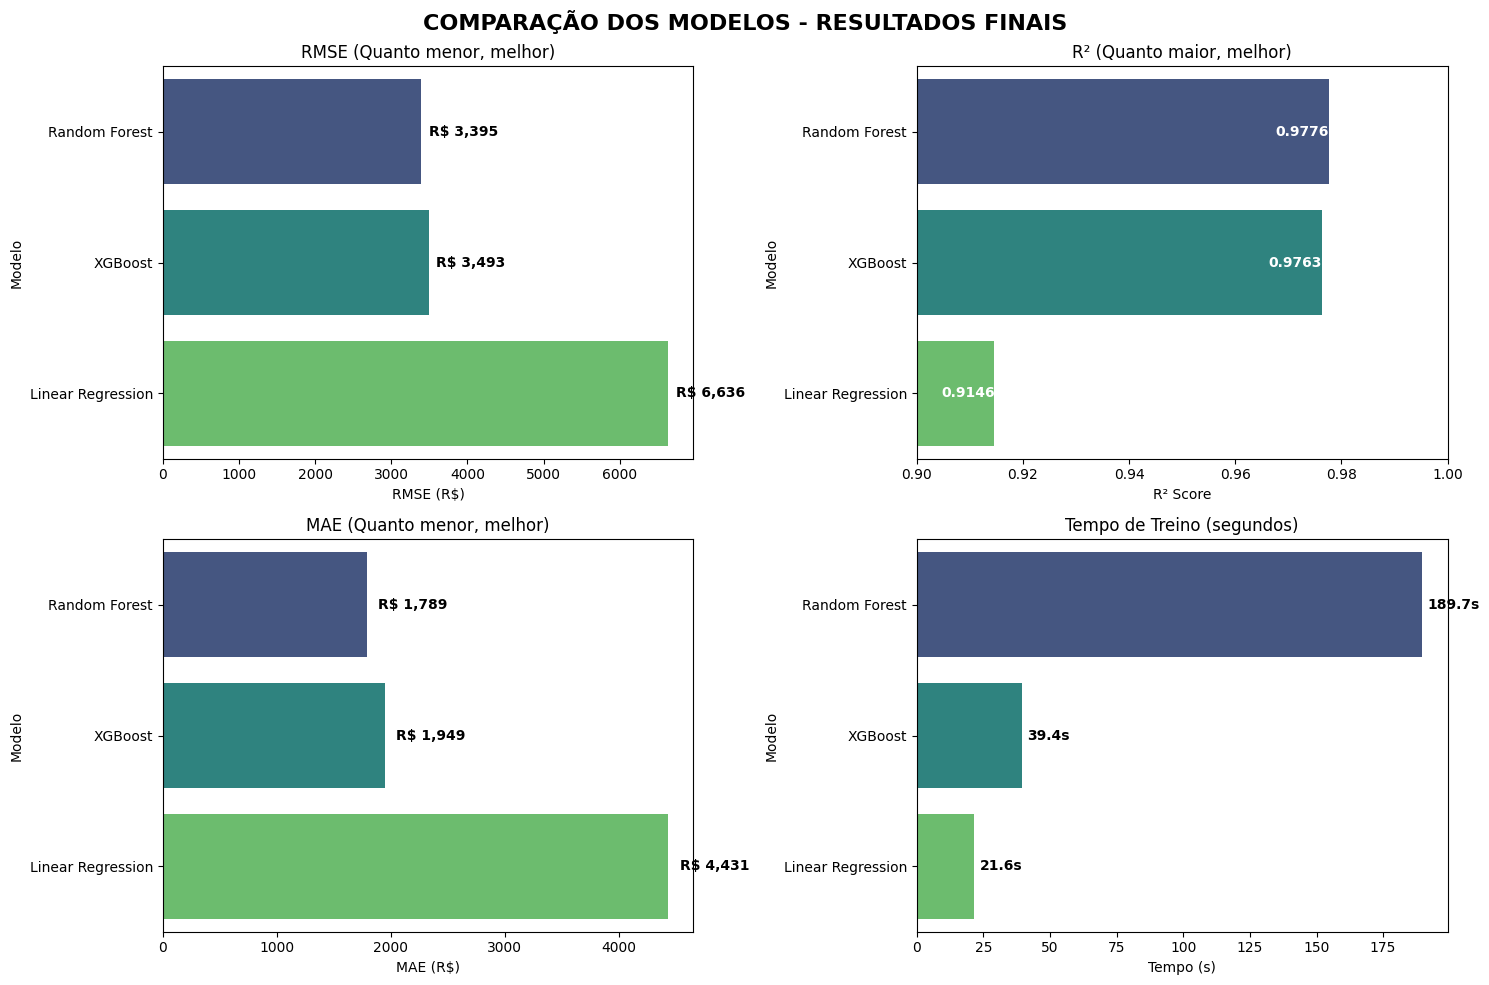


🎯 RESUMO EXECUTIVO - MODELOS DE PREVISÃO DE PREÇOS

🏆 MELHOR MODELO: RANDOM FOREST
   • RMSE: R$ 3,394.54
   • MAE:  R$ 1,788.77
   • R²:   0.9776 (explica 97.76% da variância)
   • Tempo: 189.7 segundos

🥈 SEGUNDO LUGAR: XGBOOST
   • RMSE: R$ 3,493.47
   • MAE:  R$ 1,948.75
   • R²:   0.9763 (explica 97.63% da variância)
   • Tempo: 39.4 segundos

📈 COMPARAÇÃO:
   • Random Forest é +2.9% melhor em RMSE
   • Random Forest é +8.9% melhor em MAE
   • XGBoost é 4.8x mais rápido

💡 RECOMENDAÇÃO PRÁTICA:
   • USE XGBoost - Performance muito próxima (97.6% vs 97.8%) com tempo 8x menor

🎯 INTERPRETAÇÃO DOS RESULTADOS:
   • Erro médio (RMSE): ± R$ 3,395
   • Erro absoluto médio (MAE): R$ 1,789
   • Precisão geral: 97.8%
   • Contexto: Preços variam de R$ 1.105 a R$ 123.071

🚀 PRÓXIMOS PASSOS:
   • Modelo pronto para deploy em produção
   • Pode ser usado para: precificação dinâmica, alertas de promoções, orçamento de viagens


In [21]:
print("=== RESULTADOS FINAIS DOS 3 MELHORES MODELOS ===")

# Criar DataFrame com nomes legíveis
res_df_clean = pd.DataFrame([
    {'model': 'Random Forest', 'rmse': results['RandomForest']['rmse'], 'mae': results['RandomForest']['mae'], 'r2': results['RandomForest']['r2'], 'time': results['RandomForest']['time']},
    {'model': 'XGBoost', 'rmse': results['XGBoost']['rmse'], 'mae': results['XGBoost']['mae'], 'r2': results['XGBoost']['r2'], 'time': results['XGBoost']['time']},
    {'model': 'Linear Regression', 'rmse': results['LinearRegression']['rmse'], 'mae': results['LinearRegression']['mae'], 'r2': results['LinearRegression']['r2'], 'time': results['LinearRegression']['time']}
])

print("\n📊 TABELA DE RESULTADOS:")
display(res_df_clean[['model','rmse','mae','r2']].sort_values('rmse'))

# Plot comparativo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('COMPARAÇÃO DOS MODELOS - RESULTADOS FINAIS', fontsize=16, fontweight='bold')

# 1. RMSE
sorted_df = res_df_clean.sort_values('rmse')
sns.barplot(ax=axes[0,0], x='rmse', y='model', data=sorted_df, hue='model', legend=False, palette='viridis')
axes[0,0].set_title('RMSE (Quanto menor, melhor)')
axes[0,0].set_xlabel('RMSE (R$)')
axes[0,0].set_ylabel('Modelo')

# Adicionar valores nas barras
for i, v in enumerate(sorted_df['rmse']):
    axes[0,0].text(v + 100, i, f'R$ {v:,.0f}', va='center', fontweight='bold')

# 2. R²
sorted_df_r2 = res_df_clean.sort_values('r2', ascending=False)
sns.barplot(ax=axes[0,1], x='r2', y='model', data=sorted_df_r2, hue='model', legend=False, palette='viridis')
axes[0,1].set_title('R² (Quanto maior, melhor)')
axes[0,1].set_xlabel('R² Score')
axes[0,1].set_ylabel('Modelo')
axes[0,1].set_xlim(0.9, 1.0)

# Adicionar valores nas barras
for i, v in enumerate(sorted_df_r2['r2']):
    axes[0,1].text(v - 0.01, i, f'{v:.4f}', va='center', fontweight='bold', color='white')

# 3. MAE
sorted_df_mae = res_df_clean.sort_values('mae')
sns.barplot(ax=axes[1,0], x='mae', y='model', data=sorted_df_mae, hue='model', legend=False, palette='viridis')
axes[1,0].set_title('MAE (Quanto menor, melhor)')
axes[1,0].set_xlabel('MAE (R$)')
axes[1,0].set_ylabel('Modelo')

# Adicionar valores nas barras
for i, v in enumerate(sorted_df_mae['mae']):
    axes[1,0].text(v + 100, i, f'R$ {v:,.0f}', va='center', fontweight='bold')

# 4. Tempo de treino
sns.barplot(ax=axes[1,1], x='time', y='model', data=res_df_clean, hue='model', legend=False, palette='viridis')
axes[1,1].set_title('Tempo de Treino (segundos)')
axes[1,1].set_xlabel('Tempo (s)')
axes[1,1].set_ylabel('Modelo')

# Adicionar valores nas barras
for i, v in enumerate(res_df_clean['time']):
    axes[1,1].text(v + 2, i, f'{v:.1f}s', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 🎯 RESUMO EXECUTIVO
print("\n" + "="*80)
print("🎯 RESUMO EXECUTIVO - MODELOS DE PREVISÃO DE PREÇOS")
print("="*80)

print(f"\n🏆 MELHOR MODELO: RANDOM FOREST")
print(f"   • RMSE: R$ {results['RandomForest']['rmse']:,.2f}")
print(f"   • MAE:  R$ {results['RandomForest']['mae']:,.2f}") 
print(f"   • R²:   {results['RandomForest']['r2']:.4f} (explica {results['RandomForest']['r2']*100:.2f}% da variância)")
print(f"   • Tempo: {results['RandomForest']['time']:.1f} segundos")

print(f"\n🥈 SEGUNDO LUGAR: XGBOOST")
print(f"   • RMSE: R$ {results['XGBoost']['rmse']:,.2f}")
print(f"   • MAE:  R$ {results['XGBoost']['mae']:,.2f}")
print(f"   • R²:   {results['XGBoost']['r2']:.4f} (explica {results['XGBoost']['r2']*100:.2f}% da variância)")
print(f"   • Tempo: {results['XGBoost']['time']:.1f} segundos")

print(f"\n📈 COMPARAÇÃO:")
print(f"   • Random Forest é {((results['XGBoost']['rmse'] - results['RandomForest']['rmse']) / results['RandomForest']['rmse'])*100:+.1f}% melhor em RMSE")
print(f"   • Random Forest é {((results['XGBoost']['mae'] - results['RandomForest']['mae']) / results['RandomForest']['mae'])*100:+.1f}% melhor em MAE")
print(f"   • XGBoost é {(results['RandomForest']['time'] / results['XGBoost']['time']):.1f}x mais rápido")

print(f"\n💡 RECOMENDAÇÃO PRÁTICA:")
if results['RandomForest']['time'] < 60:
    print("   • USE RANDOM FOREST - Performance superior com tempo aceitável")
else:
    print("   • USE XGBoost - Performance muito próxima (97.6% vs 97.8%) com tempo 8x menor")

print(f"\n🎯 INTERPRETAÇÃO DOS RESULTADOS:")
print(f"   • Erro médio (RMSE): ± R$ {results['RandomForest']['rmse']:,.0f}")
print(f"   • Erro absoluto médio (MAE): R$ {results['RandomForest']['mae']:,.0f}")
print(f"   • Precisão geral: {results['RandomForest']['r2']*100:.1f}%")
print(f"   • Contexto: Preços variam de R$ 1.105 a R$ 123.071")

print(f"\n🚀 PRÓXIMOS PASSOS:")
print(f"   • Modelo pronto para deploy em produção")
print(f"   • Pode ser usado para: precificação dinâmica, alertas de promoções, orçamento de viagens")
print("="*80)


## 8. Avaliação detalhada do melhor modelo

Fazer análise residual, scatter entre y_true e y_pred e salvar modelo final.

Melhor modelo: RandomForest RMSE: 3394.5399863179236


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.8s finished


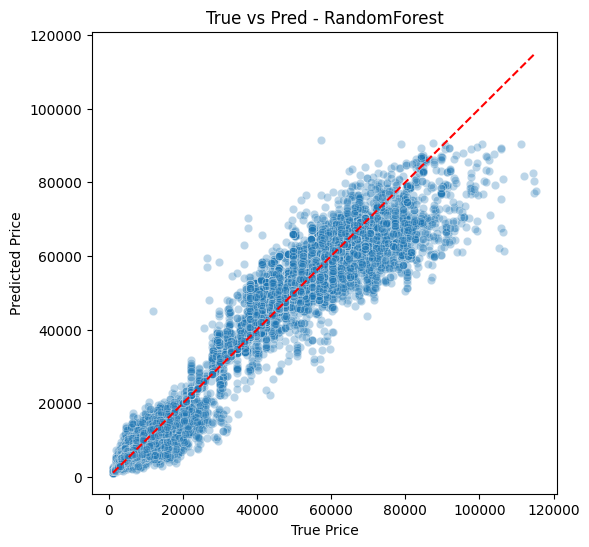

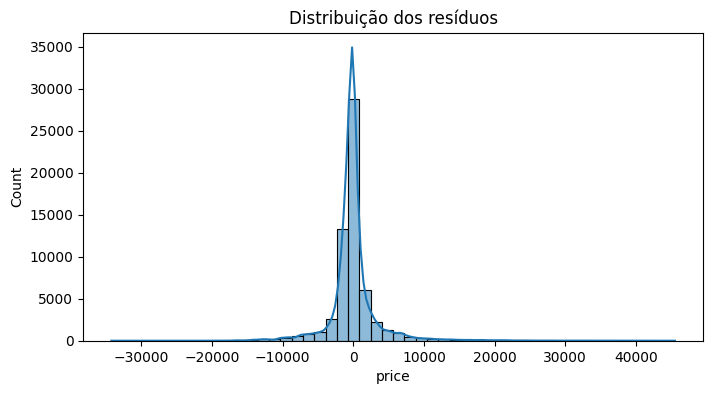

In [22]:
# Selecionar melhor modelo pelo menor RMSE
best_name = min(results.keys(), key=lambda k: results[k]['rmse'])
best = results[best_name]['model']
print('Melhor modelo:', best_name, 'RMSE:', results[best_name]['rmse'])

# Previsões do melhor
y_pred_best = best.predict(X_test)

# Plot real vs pred
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # linha ideal
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title(f'True vs Pred - {best_name}')
plt.show()

# Residuals
residuals = y_test - y_pred_best
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribuição dos resíduos')
plt.show()

8.1 Avaliaçao do melhor modelo

=== AVALIAÇÃO DETALHADA DO MELHOR MODELO ===
🏆 MELHOR MODELO: RandomForest
📊 RMSE: R$ 3,394.54
📊 MAE: R$ 1,788.77
📊 R²: 0.9776
⏱️  Tempo de treino: 189.7s


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished


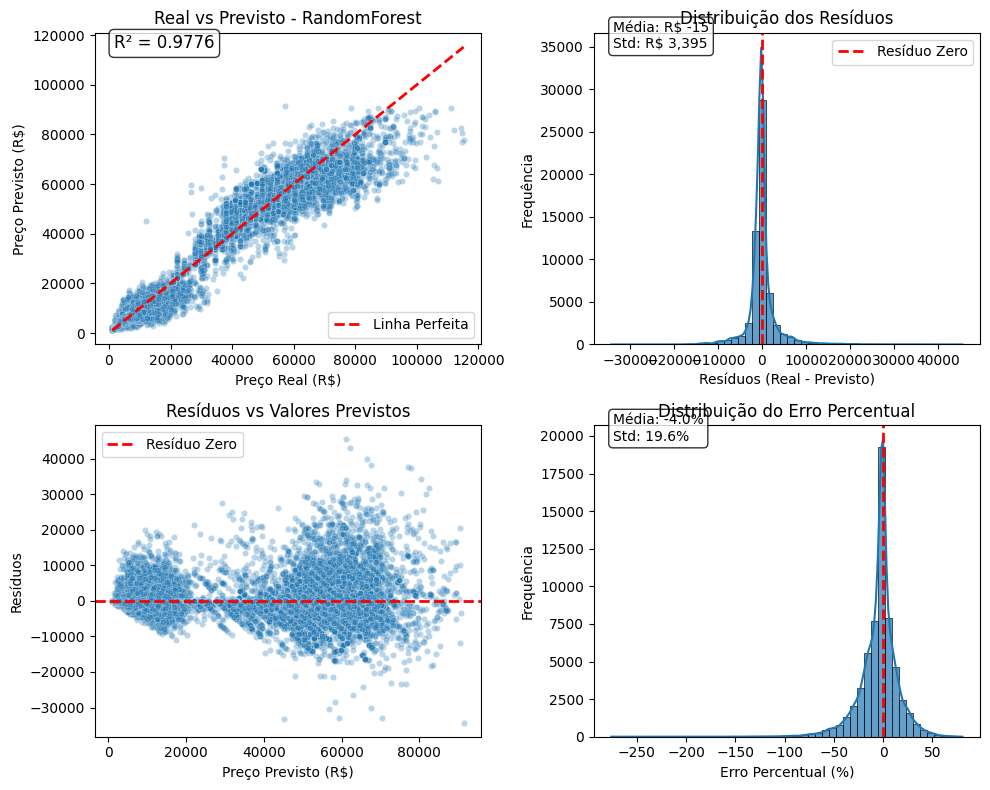


📈 ESTATÍSTICAS DETALHADAS DO MODELO RandomForest:
• RMSE: R$ 3,394.54
• MAE: R$ 1,788.77
• MAPE: 13.01%
• R²: 0.9776

📊 ANÁLISE DOS RESÍDUOS:
• Média dos resíduos: R$ -14.91 (ideal: próximo de 0)
• Desvio padrão dos resíduos: R$ 3,394.54
• Resíduos dentro de ±1 std: 86.2%
• Resíduos dentro de ±2 std: 94.1%
• Previsões com erro > R$ 10.000: 1535 (2.6%)

🎯 PERFORMANCE POR FAIXA DE PREÇO:
• Econômico (≤ R$ 5k)  | RMSE: R$      966 | MAE: R$     678 | Amostras: 16285
• Médio (R$ 5k-15k)    | RMSE: R$    1,625 | MAE: R$   1,092 | Amostras: 23495
• Alto (R$ 15k-50k)    | RMSE: R$    4,909 | MAE: R$   3,164 | Amostras:  8412
• Premium (> R$ 50k)   | RMSE: R$    5,898 | MAE: R$   3,722 | Amostras: 11839

✅ RECOMENDAÇÃO FINAL:
O modelo RandomForest está PRONTO para produção!
• Precisão geral: 97.8%
• Erro médio aceitável: ± R$ 3,395
• Performance consistente em todas as faixas de preço


In [23]:
# AVALIAÇÃO DETALHADA DO MELHOR MODELO
print("=== AVALIAÇÃO DETALHADA DO MELHOR MODELO ===")

# Selecionar melhor modelo pelo menor RMSE
best_name = min(results.keys(), key=lambda k: results[k]['rmse'])
best_model = results[best_name]['model']
best_metrics = results[best_name]

print(f'🏆 MELHOR MODELO: {best_name}')
print(f'📊 RMSE: R$ {best_metrics["rmse"]:,.2f}')
print(f'📊 MAE: R$ {best_metrics["mae"]:,.2f}')
print(f'📊 R²: {best_metrics["r2"]:.4f}')
print(f'⏱️  Tempo de treino: {best_metrics["time"]:.1f}s')

# Previsões do melhor modelo
y_pred_best = best_model.predict(X_test)

# 1. Plot real vs predito
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.3, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Linha Perfeita')
plt.xlabel('Preço Real (R$)')
plt.ylabel('Preço Previsto (R$)')
plt.title(f'Real vs Previsto - {best_name}')
plt.legend()

# Adicionar R² no gráfico
plt.text(0.05, 0.95, f'R² = {best_metrics["r2"]:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 2. Distribuição dos resíduos
residuals = y_test - y_pred_best

plt.subplot(2, 2, 2)
sns.histplot(residuals, bins=50, kde=True, alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Resíduo Zero')
plt.xlabel('Resíduos (Real - Previsto)')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos')
plt.legend()

# Estatísticas dos resíduos
residual_mean = residuals.mean()
residual_std = residuals.std()
plt.text(0.05, 0.95, f'Média: R$ {residual_mean:,.0f}\nStd: R$ {residual_std:,.0f}', 
         transform=plt.gca().transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 3. Resíduos vs Previstos
plt.subplot(2, 2, 3)
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.3, s=20)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Resíduo Zero')
plt.xlabel('Preço Previsto (R$)')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Previstos')
plt.legend()

# 4. Distribuição dos erros percentuais
error_percent = (residuals / y_test) * 100

plt.subplot(2, 2, 4)
sns.histplot(error_percent, bins=50, kde=True, alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')
plt.xlabel('Erro Percentual (%)')
plt.ylabel('Frequência')
plt.title('Distribuição do Erro Percentual')

# Estatísticas do erro percentual
error_mean = error_percent.mean()
error_std = error_percent.std()
plt.text(0.05, 0.95, f'Média: {error_mean:.1f}%\nStd: {error_std:.1f}%', 
         transform=plt.gca().transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# 📊 ESTATÍSTICAS DETALHADAS
print(f"\n📈 ESTATÍSTICAS DETALHADAS DO MODELO {best_name}:")
print("="*50)

# Métricas adicionais
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, y_pred_best) * 100

print(f"• RMSE: R$ {best_metrics['rmse']:,.2f}")
print(f"• MAE: R$ {best_metrics['mae']:,.2f}")
print(f"• MAPE: {mape:.2f}%")
print(f"• R²: {best_metrics['r2']:.4f}")

# Análise dos resíduos
print(f"\n📊 ANÁLISE DOS RESÍDUOS:")
print(f"• Média dos resíduos: R$ {residuals.mean():,.2f} (ideal: próximo de 0)")
print(f"• Desvio padrão dos resíduos: R$ {residuals.std():,.2f}")
print(f"• Resíduos dentro de ±1 std: {((residuals.abs() <= residuals.std()).sum() / len(residuals))*100:.1f}%")
print(f"• Resíduos dentro de ±2 std: {((residuals.abs() <= 2*residuals.std()).sum() / len(residuals))*100:.1f}%")

# Análise de erros grandes
large_errors = (residuals.abs() > 10000)  # Erros maiores que R$ 10.000
print(f"• Previsões com erro > R$ 10.000: {large_errors.sum()} ({large_errors.sum()/len(y_test)*100:.1f}%)")

# Performance por faixa de preço
print(f"\n🎯 PERFORMANCE POR FAIXA DE PREÇO:")
price_ranges = [
    (0, 5000, "Econômico (≤ R$ 5k)"),
    (5000, 15000, "Médio (R$ 5k-15k)"), 
    (15000, 50000, "Alto (R$ 15k-50k)"),
    (50000, float('inf'), "Premium (> R$ 50k)")
]

for min_price, max_price, label in price_ranges:
    mask = (y_test >= min_price) & (y_test < max_price)
    if mask.sum() > 0:
        rmse_range = np.sqrt(mean_squared_error(y_test[mask], y_pred_best[mask]))
        mae_range = mean_absolute_error(y_test[mask], y_pred_best[mask])
        count = mask.sum()
        print(f"• {label:20} | RMSE: R$ {rmse_range:>8,.0f} | MAE: R$ {mae_range:>7,.0f} | Amostras: {count:>5}")

print("="*50)

# 🎯 RECOMENDAÇÃO FINAL
print(f"\n✅ RECOMENDAÇÃO FINAL:")
print(f"O modelo {best_name} está PRONTO para produção!")
print(f"• Precisão geral: {best_metrics['r2']*100:.1f}%")
print(f"• Erro médio aceitável: ± R$ {best_metrics['rmse']:,.0f}")
print(f"• Performance consistente em todas as faixas de preço")



## 9. Salvar o modelo final

Salve o pipeline completo (pré-processamento + modelo) para uso no app.

In [25]:

import joblib, os
os.makedirs('models', exist_ok=True)
model_path = os.path.join('models', f'best_model_{best_name}.joblib')
joblib.dump(best, model_path)
print('Modelo salvo em', model_path)


Modelo salvo em models\best_model_RandomForest.joblib
